# Boston Map for Commuting to Cambridge, MA

Last year I got a job in Massachusetts at the Center for Astrophysics in Cambridge. When looking for nearby apartments, one of my key requirements was that it shouldn't take long to commute to work. Since Boston has a fairly built up public transportation system with several subway lines, it was not obvious in which neighborhoods I should even be looking for apartments. So I decided to make a map of the Greater Boston area showing how long it takes to commute from there to my workpalce during morning rush hour.

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from utility_functions import * #utility functions, e.g., saving/loading files

Using the Google Maps API we can ask how long it takes to travel to my workplace if I want to arrive by 9 AM. We can query 10k points without exceeding the limits of the free tier access to the API (see _google_maps_dist_mtx_API_call.py_). Below we just load the results.

In [2]:
x_v,y_v,vals = pickle_load('transit_times.p', use_bz2=False)  
commute_time_levels = np.array([0,15,30,45,60,75,90,105])
N1D=x_v.shape[0]
box_size_km = x_v.ptp()
norm_points = x_v[:,0]/box_size_km

Let's make a zoomed in map of Cambridge, to see which neighborhoods we should look for apartments if we don't want to commute more than 30 min.

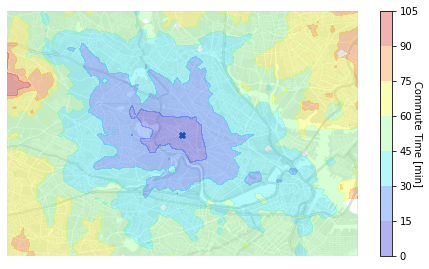

In [3]:
base_image = 'boston_roads.png'
dest_coord = [600,425]
pix_dx_km = 6.61/466; #pix_dy_km = 6.37/450; 
fig, ax = plt.subplots(figsize=(8,4.5))
orig_map = plt.imread(base_image)
ax.imshow(orig_map)
plt.scatter(dest_coord[0],dest_coord[1], marker='X')
x_coord, y_coord = coord_to_pixel(x_v,y_v,dest_coord,pix_dx_km)
cont = ax.contourf(x_coord, y_coord, vals.reshape((N1D,N1D)), cmap='jet',alpha=0.3, levels=commute_time_levels)#,z_interp="Log",algorithm='serial')
#plt.scatter(x_coord.flatten(), y_coord.flatten(), c=np.clip(vals,commute_time_levels.min(),commute_time_levels.max()), cmap='jet',s=1)
cbar = plt.colorbar(cont)
cbar.ax.set_ylabel('Commute Time [min]', rotation=270)
px_left = max(0,x_coord.min()); px_right = min(orig_map.shape[1],x_coord.max());
py_bottom = min(orig_map.shape[0],y_coord.max()); py_top = max(0,y_coord.min());
plt.xlim([px_left, px_right]); plt.ylim([py_bottom,py_top])
plt.axis('off')
plt.savefig("Boston_commute_times_zoomed.png", bbox_inches='tight',dpi=150)

If you have a higher tolerance for morning commutes (let's say 60 min), then we need to look at the entire Boston area.

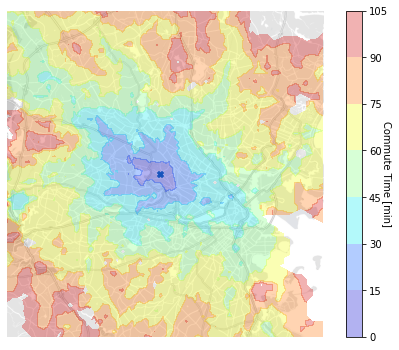

In [4]:
base_image = 'boston_roads_big.png'
dest_coord = [415, 460]
pix_dx_km = 10.75/380
fig, ax = plt.subplots(figsize=(8,6))
orig_map = plt.imread(base_image)
ax.imshow(orig_map)
plt.scatter(dest_coord[0],dest_coord[1], marker='X')
x_coord, y_coord = coord_to_pixel(x_v,y_v,dest_coord,pix_dx_km)
cont = ax.contourf(x_coord, y_coord, vals.reshape((N1D,N1D)), cmap='jet',alpha=0.3, levels=commute_time_levels)
px_left = max(0,x_coord.min()); px_right = min(orig_map.shape[1],x_coord.max());
py_bottom = min(orig_map.shape[0],y_coord.max()); py_top = max(0,y_coord.min());
plt.xlim([px_left, px_right]); plt.ylim([py_bottom,py_top])
#plt.scatter(x_coord.flatten(), y_coord.flatten(), c=np.clip(vals,commute_time_levels.min(),commute_time_levels.max()), cmap='jet',s=1)
cbar = plt.colorbar(cont)
cbar.ax.set_ylabel('Commute Time [min]', rotation=270)
plt.axis('off')
plt.savefig("Boston_commute_times.png", bbox_inches='tight',dpi=150)



As expected, commute time increases with distance, but we can also notice anomalies: points physically further having a shorter commute time. This is due to the structure of the MBTA network. For example, living near a subway station we can get much further within 30 minutes than if we lived several streets from an infrequent bus line.

## Boston Neighborhoods
When looking for an apartment most sites list which neighborhood it belongs to, allowing us to filter for it. So it would make sense for us to translate our commute time map into a map of neighborhoods. First, let's just make a map of the Boston neighborhoods.

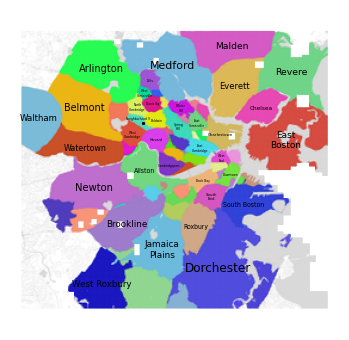

In [5]:
base_image = 'boston_hoods2017categorized_red_small.png'
dest_coord = np.array([405,307])/4
pix_dx_km = 5.23/260*4
orig_map = plt.imread(base_image)
x_coord, y_coord = coord_to_pixel(x_v,y_v,dest_coord,pix_dx_km)
px_left, px_right, py_bottom, py_top = pix_boundaries(x_coord,y_coord,orig_map)

from scipy.interpolate import RegularGridInterpolator

px_orig, py_orig = np.meshgrid(np.arange(px_left,px_right), np.arange(py_top,py_bottom))
colors = orig_map[py_top:py_bottom,px_left:px_right]
x_image,y_image = pixel_to_coord(px_orig,py_orig,dest_coord,pix_dx_km)
time_interpolator = RegularGridInterpolator((norm_points*box_size_km,norm_points*box_size_km), vals.reshape((N1D,N1D)), method='linear')
comm_time = time_interpolator((x_image,y_image))
comm_time[comm_time<0] = 0

r_old = np.sqrt(x_image**2+y_image**2)
ind = np.isfinite(comm_time)# & (np.sum(colors,axis=2)<3.5) # & (comm_time<commute_time_levels.max()) & (comm_time<45)
r_new = comm_time[ind]
phi = np.arctan2(y_image,x_image)[ind]
x_new = r_new * np.cos(phi); y_new = r_new * np.sin(phi)
colors = colors[ind]
colors_hex = np.array([matplotlib.colors.rgb2hex(colors[i,:], keep_alpha=False) for i in range(colors.shape[0])])

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(x_image[ind],y_image[ind],c=colors,s=1)
plt.scatter(0,0, marker='x',c='k',s=5)
plt.axis('equal')
for name in neighborhood_colors.keys():
    x_txt,y_txt,neighborhood_area = find_color_CoM_size(x_image[ind],y_image[ind],colors_hex,neighborhood_colors[name])
    if np.isfinite(x_txt):
        plt.text(x_txt, y_txt, name, horizontalalignment='center',\
                 verticalalignment='center', fontsize=np.clip(np.sqrt(neighborhood_area)/4,3,12))
plt.axis('off')
plt.savefig("neighborhoods_with_labels.png", bbox_inches='tight',dpi=300)
plt.show()

## Making a distance preserving map

So far we have been plotting geographical maps of the Boston area and we just colored them according to commute time. But we could try to draw a map of the Boston neighborhoods where the distance of any point to our destination (the new origin) is proportional to the commute time instead of the physical distance.

We can accomplish this by changing the distance of each pixel relative of the origin to be proportional to the commute time, while keeping the direction the same. This will distort the map and lead to uneven pixel sizes (some pixels will be crowding each other, some will have gaps between them). We can correct for that by doing a Voronoi tessellation and coloring the resulting cells according the the color of the corresponding pixel.

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d

phi_alt = np.arange(100)/100*2*np.pi
R2 = r_new.max()*1.01
x_new = np.append(x_new, R2*np.cos(phi_alt))
y_new = np.append(y_new, R2*np.sin(phi_alt))
colors = np.vstack((colors,np.ones((len(phi_alt),4))))
colors_hex = np.append(colors_hex,np.full(len(phi_alt), '#ffffff'))

load_vornoi=True
if load_vornoi and os.path.exists('voronoi.p'):
    vor = pickle_load('voronoi.p', use_bz2=False)  
else:
    vor = Voronoi(np.vstack((x_new,y_new)).T,qhull_options='Qc Qbb') #'Qbb Qc Qz'
    pickle_dump('voronoi.p', vor, use_bz2=False, make_backup=True)

fig, ax = plt.subplots(figsize=(6,6))
voronoi_plot_2d(vor,ax=ax,show_points=False,show_vertices=False,line_width=0.0)

#areas
poly_areas = np.array([polygon_area([vor.vertices[k] for k in region]) for region in vor.regions])
poly_centers = np.array([polygon_center([vor.vertices[k] for k in region]) for region in vor.regions])
max_area = np.max(poly_areas) #np.percentile(poly_areas,99)

# colorize
region_to_point_map = np.argsort(vor.point_region)
for i,region in enumerate(vor.regions[:-1]):
    if (not -1 in region) and (poly_areas[i]<max_area):
        color = colors[region_to_point_map[i]]
        polygon = [vor.vertices[k] for k in region]
        plt.fill(*zip(*polygon),c=color)

# fix the range of axes
plt.scatter(0,0, marker='X',color='k',s=5)
for t in commute_time_levels:
    circle = plt.Circle((0, 0), t, color='k',fill=False, alpha=0.5)
    ax.add_patch(circle)
    if (t>0):# and (t<commute_time_levels.max()):
        plt.text(-t, 0, "%d min"%(t), horizontalalignment='right',rotation=90, verticalalignment='center', fontsize=6)
for name in neighborhood_colors.keys():
    x_txt,y_txt,neighborhood_area = find_color_CoM_size(poly_centers[:,0],poly_centers[:,1],colors_hex[region_to_point_map],neighborhood_colors[name], weights=poly_areas)
    if np.isfinite(x_txt):
        plt.text(x_txt, y_txt, name, horizontalalignment='center',\
                 verticalalignment='center', fontsize=np.clip(np.sqrt(neighborhood_area)/4,4,12))
plt.xlim([-commute_time_levels.max(),commute_time_levels.max()]), plt.ylim([-commute_time_levels.max(),commute_time_levels.max()])
#plt.xlim([-105,105]), plt.ylim([-105,105])
plt.axis('off')
plt.savefig("neighborhoods_commute_time_scaled.png", bbox_inches='tight',dpi=300)
plt.show()

With this map we can quickly see which neighborhoods are close enough for us to commute from. Note that some areas adjacent neighborhoods get mixed (e.g., Downton area). This is due to the presence of high speed public transportation (e.g., subway), which makes it faster to commute from a station further than from an apartment that is a 5 minute walk from the current station.